# Read Data

In [1]:
#read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import numpy as np
import pymc as pm
import arviz as az





def read_data_json(file):
    with open(file) as f:
        data = json.load(f)
    trajectories = {traj['UniqueID']: parse_array(traj['Trajectory']) for traj in data['Trajectories']}
    currents = {traj['UniqueID']: parse_array(traj['Current']) for traj in data['Trajectories']}
    gyro = {traj['UniqueID']: parse_array(traj['Gyro']) for traj in data['Trajectories']}
    accel = {traj['UniqueID']: parse_array(traj['Accel']) for traj in data['Trajectories']}
    angles = {traj['UniqueID']: parse_array(traj['Angles']) for traj in data['Trajectories']}
    return trajectories, currents, gyro, accel, angles

def parse_array(traj):
    return np.array(traj)



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
positions, currents, gyro, accel, angles = read_data_json('data/TrajectoriesTorso.json')

In [3]:
from collections import defaultdict

# Calculate the average current for specific position and distance to goal
servos = [0, 1]
avg_current_data = {}
for servo in servos:
    current_data = defaultdict(list)
    x, y, z = [], [], []

    for trajectory in currents.keys():
        # Collect data points for starting position and distance to goal
        current_vals = currents[trajectory][:, servo]
        trajectory_vals = positions[trajectory][:, servo]
        goal_pos = trajectory_vals[-1]
        distances_to_goal = np.round(abs(trajectory_vals - goal_pos), 2)

        for pos, dist_to_goal, curr in zip(trajectory_vals, distances_to_goal, current_vals):
            # Convert to int to avoid float precision issues
            pos = int(pos)
            dist_to_goal = int(dist_to_goal)
            current_data[(pos, dist_to_goal)].append(curr)

    servoname = "NeckTilt" if servo == 0 else "NeckPan"
    # Create a DataFrame for each servo
    avg_current_data[servoname] = pd.DataFrame([
        {'Position': pos, 'DistanceToGoal': dist, 'AvgCurrent': np.mean(np.abs(currents))}
        for (pos, dist), currents in current_data.items()
    ])


In [4]:
avg_current_data["NeckPan"]

Position  DistanceToGoal  AvgCurrent
0          192               6   36.960000
1          191               5   48.414545
2          190               4   30.240000
3          189               3   28.332973
4          188               2   34.160000
...        ...             ...         ...
6621       143              86   20.160000
6622       145              84   23.520000
6623       145              83   20.160000
6624       146              82   28.560000
6625       229              15   43.680000

[6626 rows x 3 columns]

In [5]:
#normalize and standardize data
std_avg_current_data = {}
for servo, data in avg_current_data.items():
    dat = data.copy()
    dat['Position'] = (dat['Position'] - dat['Position'].mean()) / dat['Position'].std()
    dat['DistanceToGoal'] = (dat['DistanceToGoal'] - dat['DistanceToGoal'].mean()) / dat['DistanceToGoal'].std()
    dat['AvgCurrent'] = (dat['AvgCurrent'] - dat['AvgCurrent'].mean()) / dat['AvgCurrent'].std()
    std_avg_current_data[servo] = dat

In [6]:
# Combine the data to a dataframe 
all_data = pd.DataFrame()

for key in positions.keys():
    temp_data = pd.DataFrame()
    temp_data['tilt_pos'] = positions[key][:,0]
    temp_data['pan_pos'] = positions[key][:,1]
    temp_data['tilt_current'] = currents[key][:,0]
    temp_data['pan_current'] = currents[key][:,1]
    temp_data['gyro_x'] = gyro[key][:,0]
    temp_data['gyro_y'] = gyro[key][:,1]
    temp_data['gyro_z'] = gyro[key][:,2]
    temp_data['accel_x'] = accel[key][:,0]
    temp_data['accel_y'] = accel[key][:,1]
    temp_data['accel_z'] = accel[key][:,2]
    temp_data['tilt_distance'] = np.abs(positions[key][:,0] - positions[key][-1,0])
    temp_data['pan_distance'] = np.abs(positions[key][:,1] - positions[key][-1,1])
    all_data = pd.concat([all_data, temp_data], ignore_index=True)



In [7]:
#standardize and normalize data
std_all_data = pd.DataFrame()
for col in all_data.columns:
    std_all_data[col] = (all_data[col] - all_data[col].mean()) / all_data[col].std()


# Models on the average

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


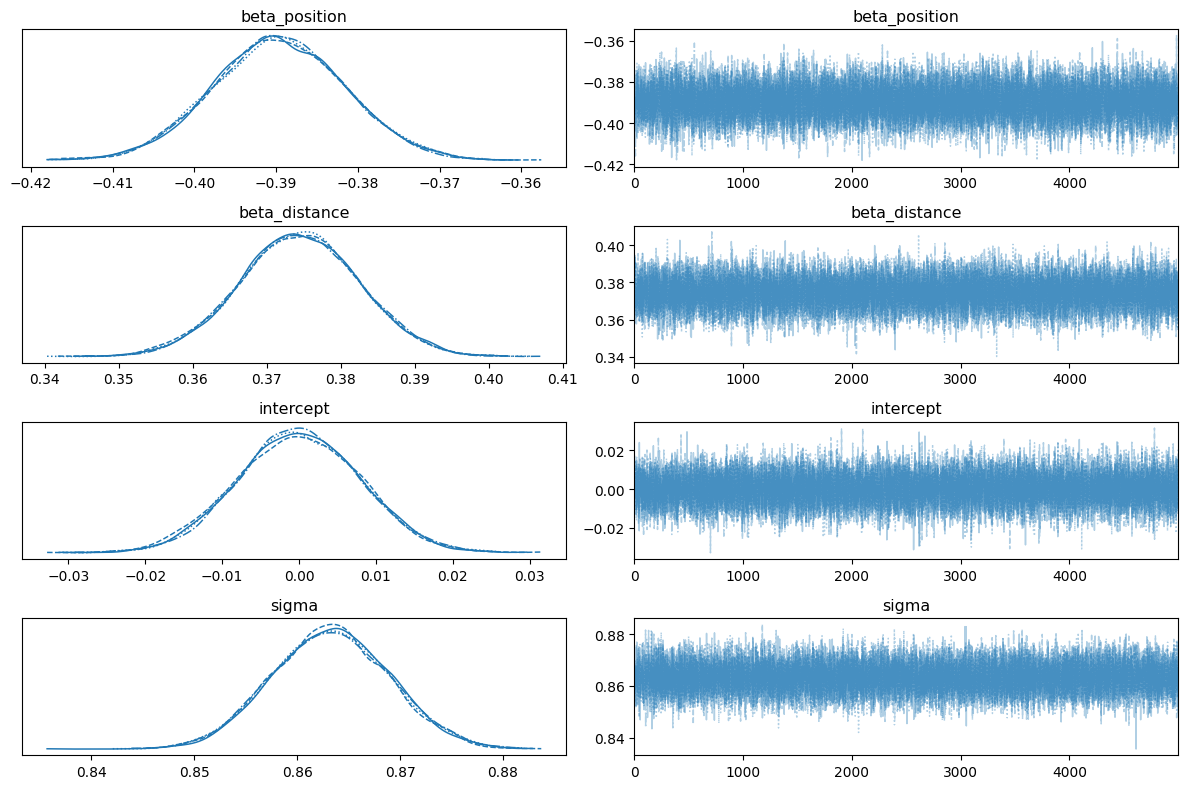

In [5]:
# Define the model
with pm.Model() as regression_tilt_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept + beta_position * std_avg_current_data["NeckTilt"]['Position'] + beta_distance * std_avg_current_data['NeckTilt']['DistanceToGoal']
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=std_avg_current_data['NeckTilt']['AvgCurrent'])
    
    # Sample from the posterior
    trace_tilt = pm.sample(5000, tune=1000, return_inferencedata=True)

az.plot_trace(trace_tilt)
plt.tight_layout()
plt.show()

In [8]:
#Posterior Predictive Checks
with regression_tilt_model:
    ppc_tilt = pm.sample_posterior_predictive(trace_tilt)


Sampling: [AvgCurrent]


Output()

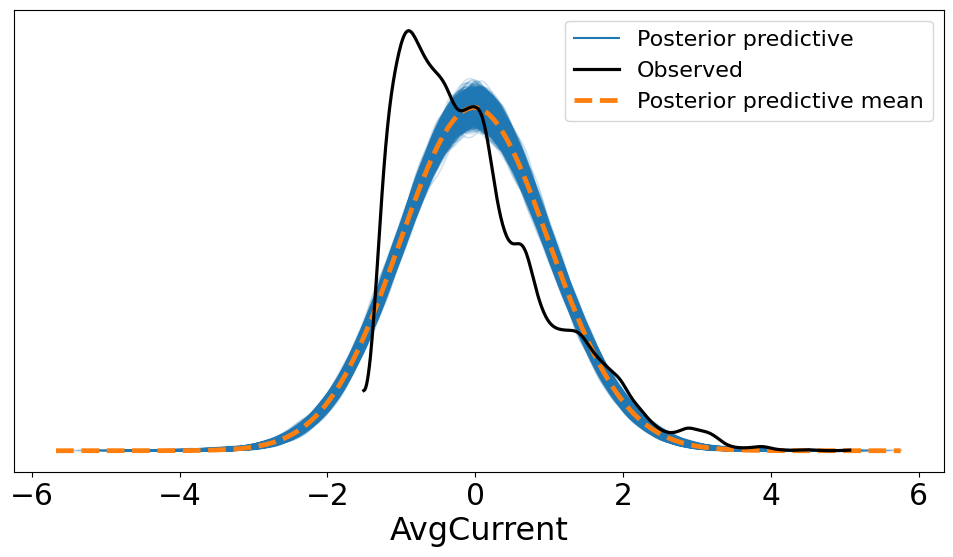

In [9]:
import matplotlib.pyplot as plt
import arviz as az


az.plot_ppc(ppc_tilt, data_pairs={"AvgCurrent": "AvgCurrent"}, figsize=(12, 6))
plt.show()

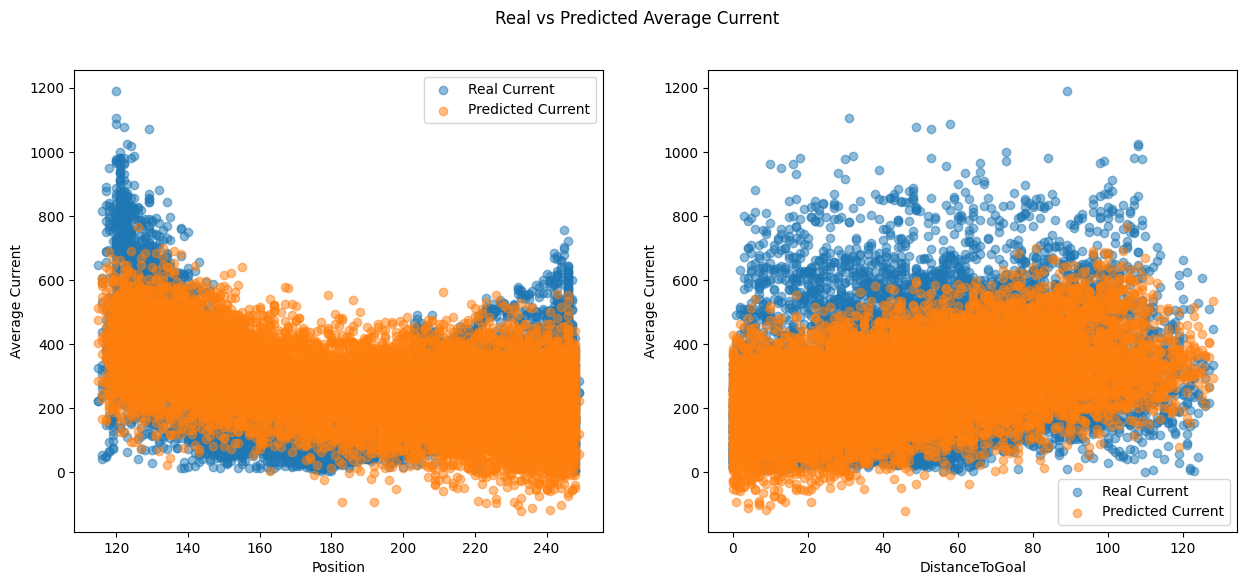

In [10]:
def plot_real_vs_predicted(data, ppc, indep_var='Position'):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive['AvgCurrent'].mean(axis=0)[1]
    avg_current_mean = dat['AvgCurrent'].mean()
    avg_current_std = dat['AvgCurrent'].std()
    predicted_current_raw = predicted_current_mean * avg_current_std + avg_current_mean
    
    if isinstance(indep_var, list):
        fig, axes = plt.subplots(1, len(indep_var), figsize=(15, 6))
        for i, var in enumerate(indep_var):
            axes[i].scatter(data[var], data['AvgCurrent'], alpha=0.5, label='Real Current')
            axes[i].scatter(data[var], predicted_current_raw, alpha=0.5, label='Predicted Current')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Average Current')
            axes[i].legend()
        plt.suptitle('Real vs Predicted Average Current')
    else:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[indep_var], data['AvgCurrent'], alpha=0.5, label='Real Current')
        plt.scatter(data[indep_var], predicted_current_raw, alpha=0.5, label='Predicted Current')
        plt.xlabel(indep_var)
        plt.ylabel('Average Current')
        plt.title('Real vs Predicted Average Current')
        plt.legend()
    plt.show()

plot_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt, indep_var=['Position', 'DistanceToGoal'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


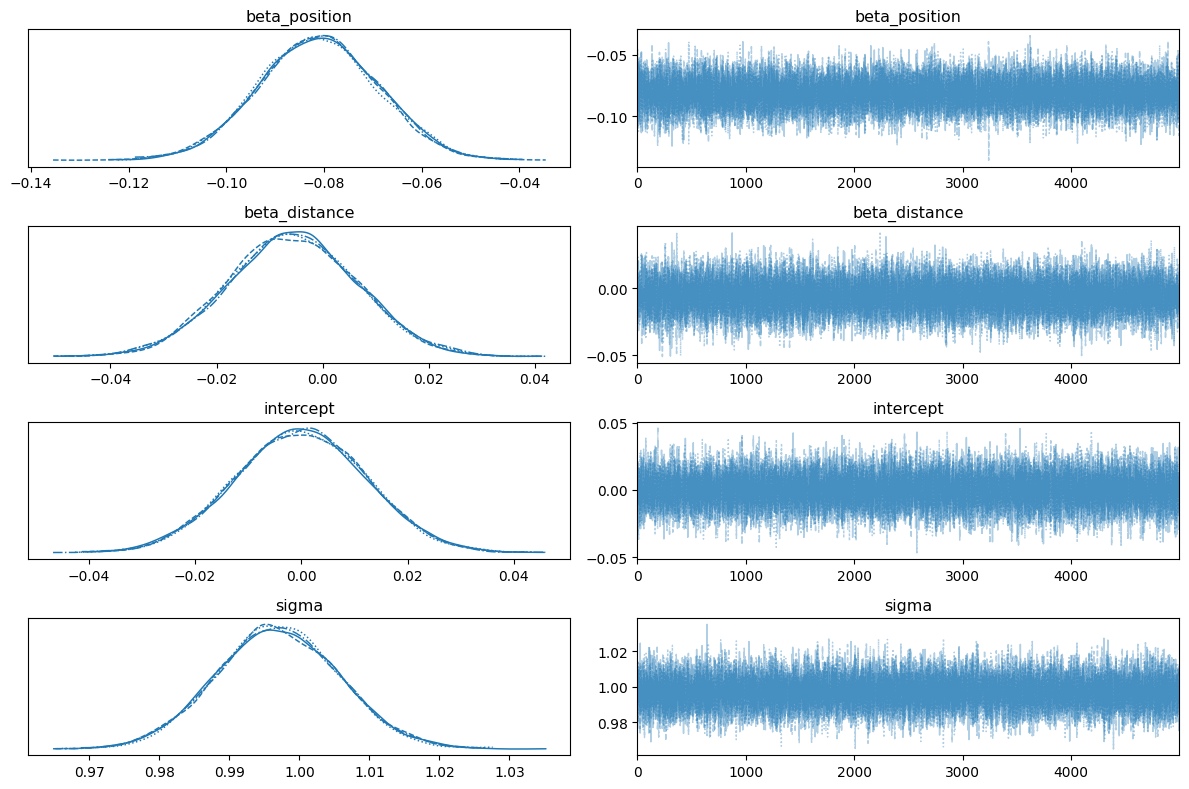

In [11]:
#New model for NeckPan
data = std_avg_current_data["NeckPan"].copy()

with pm.Model() as regression_pan_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept + beta_position * data['Position'] + beta_distance * data['DistanceToGoal']
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    # Sample from the posterior
    trace_pan = pm.sample(5000, tune=1000, return_inferencedata=True)

az.plot_trace(trace_pan)
plt.tight_layout()
plt.show()

In [12]:
#Posterior Predictive Checks
with regression_pan_model:
    ppc_pan = pm.sample_posterior_predictive(trace_pan)


Sampling: [AvgCurrent]


Output()

<Axes: xlabel='AvgCurrent'>

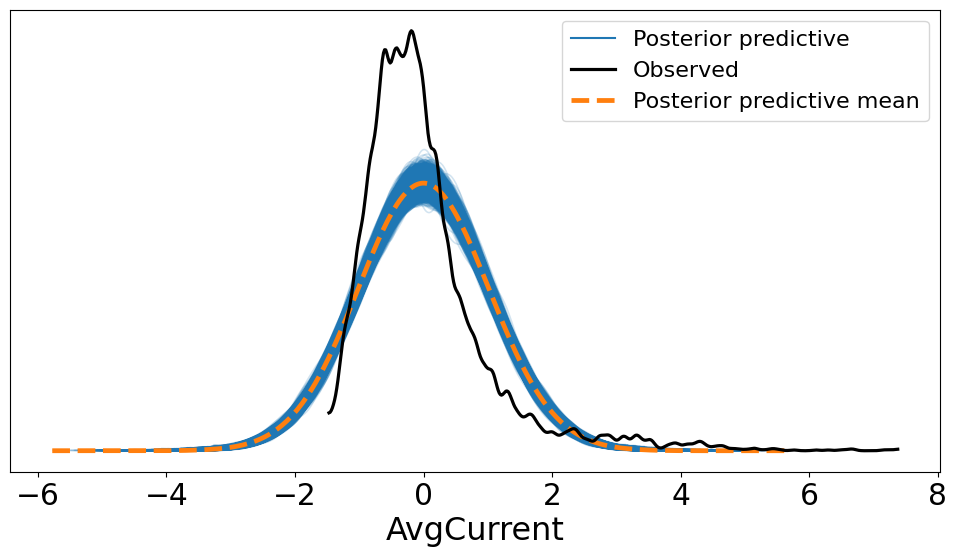

In [13]:
az.plot_ppc(ppc_pan, data_pairs={"AvgCurrent": "AvgCurrent"}, figsize=(12, 6))

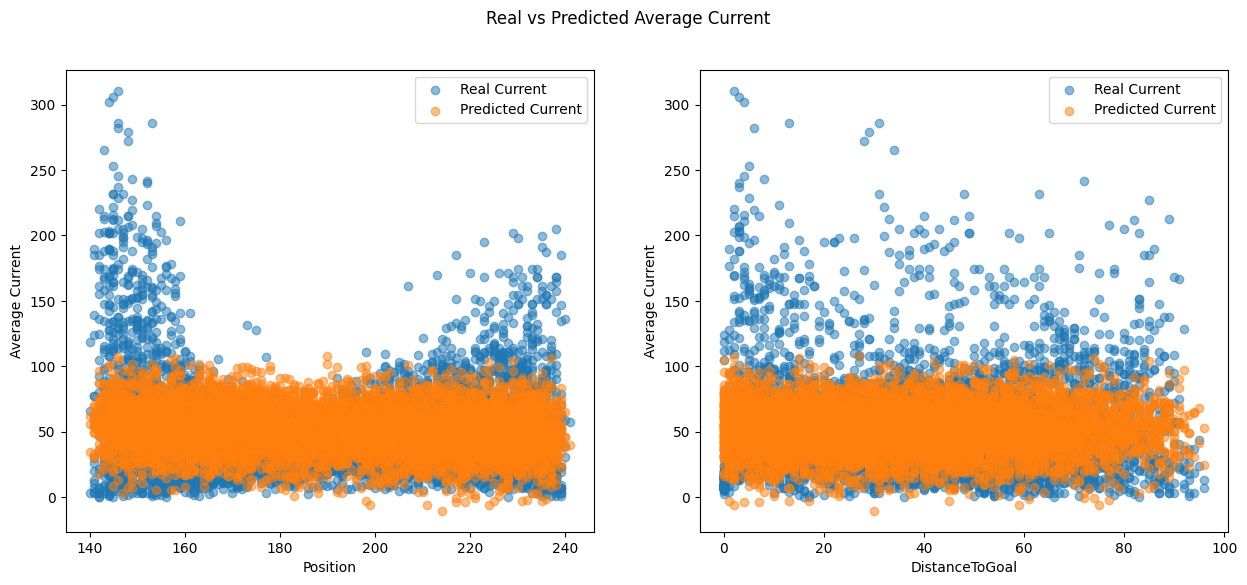

In [14]:

plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan, indep_var=['Position', 'DistanceToGoal'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, beta_position2, beta_distance2, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.


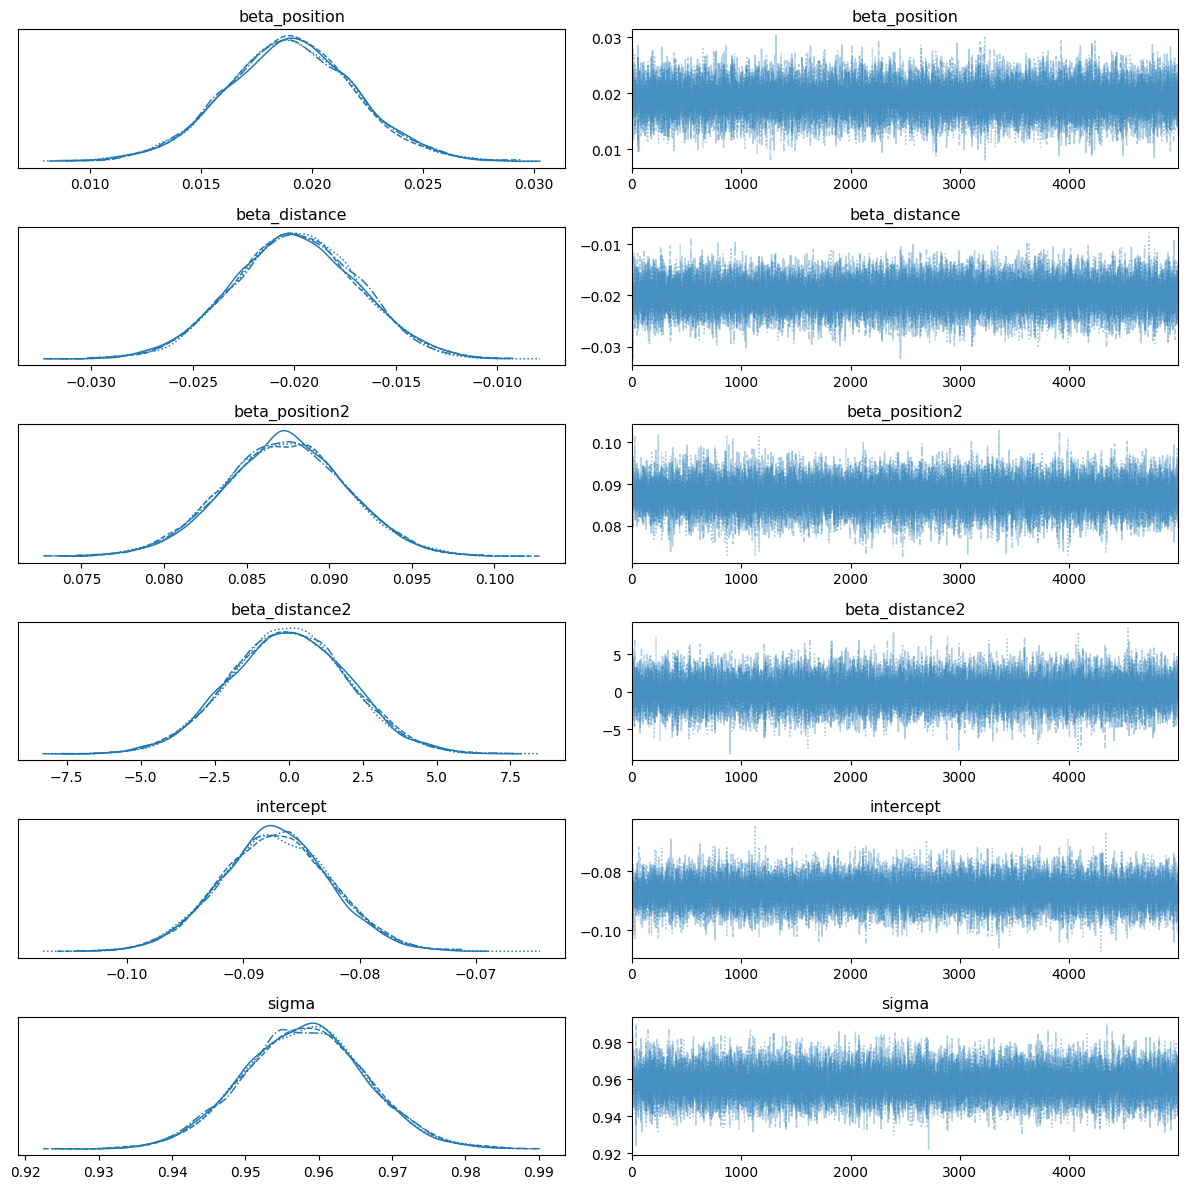

In [15]:
# New polynomial model for NeckPan
data = std_avg_current_data["NeckPan"].copy()

with pm.Model() as regression_pan_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)
    scalar = 4

    # Linear model equation
    mu = scalar*(intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2)
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    # Sample from the posterior
    trace_pan_quad = pm.sample(5000, tune=1000, return_inferencedata=True)
az.plot_trace(trace_pan_quad)
plt.tight_layout()
plt.show()

In [16]:
#Posterior Predictive Checks
with regression_pan_model:
    ppc_pan_quad = pm.sample_posterior_predictive(trace_pan_quad)


Sampling: [AvgCurrent]


Output()

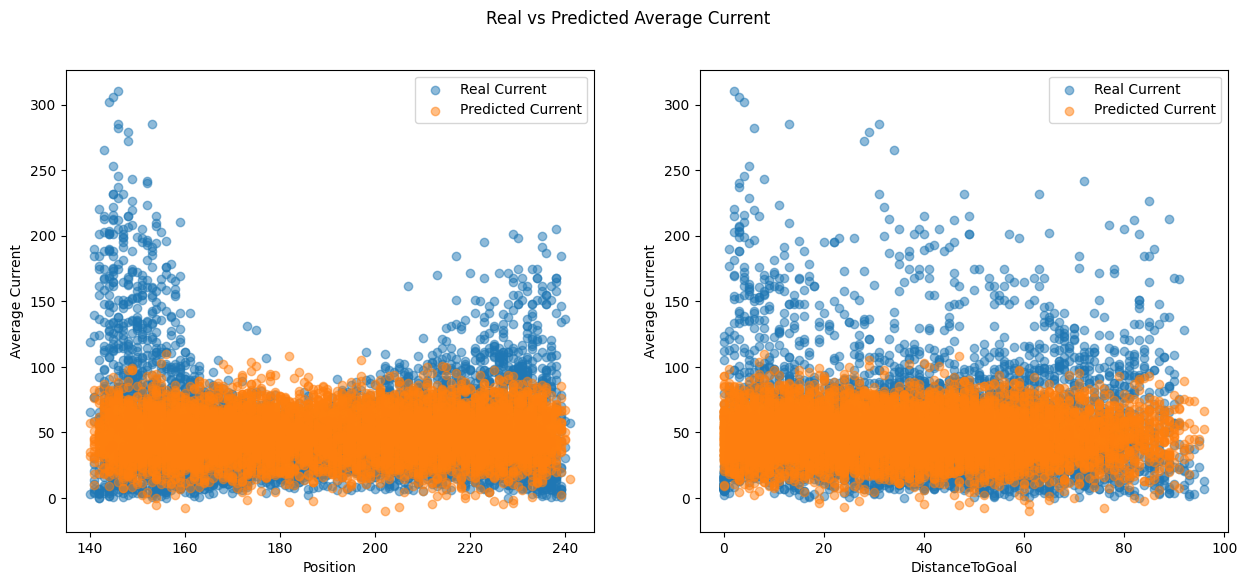

In [17]:
plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

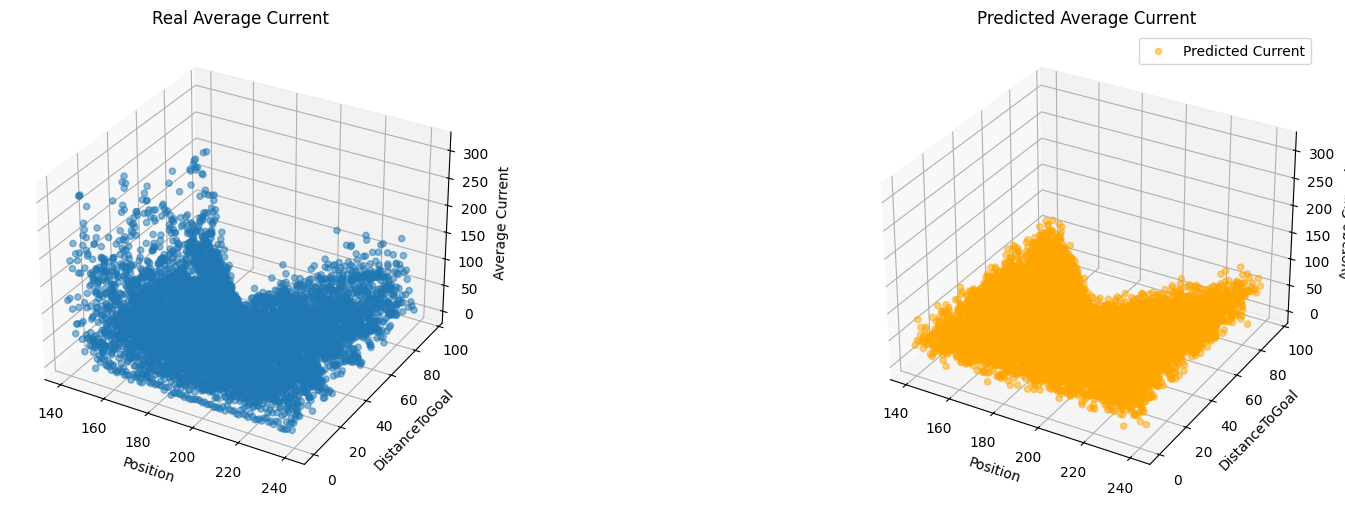

In [18]:
#plot function that plots topographic map in 3d of the real vs predicted values
def plot_3d_real_vs_predicted(data, ppc, indep_var=['Position', 'DistanceToGoal']):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive['AvgCurrent'].mean(axis=0)[1]
    avg_current_mean = dat['AvgCurrent'].mean()
    avg_current_std = dat['AvgCurrent'].std()
    predicted_current_raw = predicted_current_mean * avg_current_std + avg_current_mean
    
    fig = plt.figure(figsize=(20, 6))
    
    # Real Current subplot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(dat[indep_var[0]], dat[indep_var[1]], dat['AvgCurrent'], alpha=0.5, label='Real Current')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('DistanceToGoal')
    ax1.set_zlabel('Average Current')
    ax1.set_title('Real Average Current')
    
    # Predicted Current subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(dat[indep_var[0]], dat[indep_var[1]], predicted_current_raw, alpha=0.5, label='Predicted Current', color='orange')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('DistanceToGoal')
    ax2.set_zlabel('Average Current')
    ax2.set_title('Predicted Average Current')
    
    # Set the same axis limits for both subplots
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_zlim(ax1.get_zlim())
    
    plt.legend()
    plt.tight_layout
    plt.show()

plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

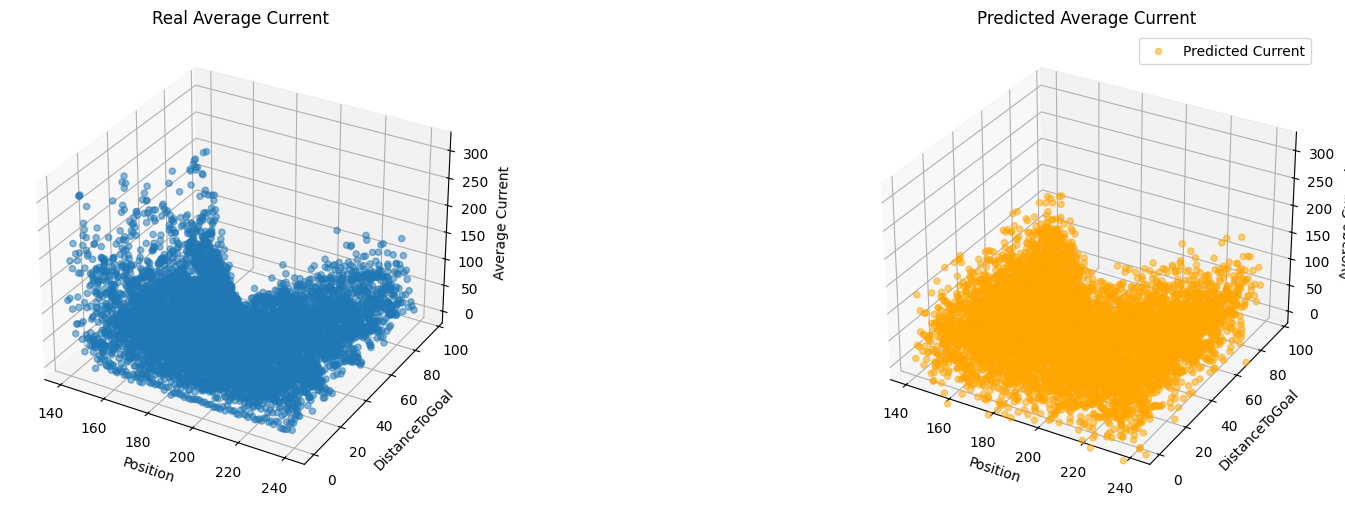

In [21]:
ppc_pan_quad_scaled = ppc_pan_quad.copy()
ppc_pan_quad_scaled.posterior_predictive['AvgCurrent']*=2.5

plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad_scaled, indep_var=['Position', 'DistanceToGoal'])

In [21]:
#Qudratic model for NeckTilt
data = std_avg_current_data["NeckTilt"].copy()

with pm.Model() as regression_tilt_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    # Sample from the posterior
    trace_tilt_quad = pm.sample(5000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, beta_position2, beta_distance2, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


In [23]:
with regression_tilt_model_quadradic:
    ppc_tilt_quad = pm.sample_posterior_predictive(trace_tilt_quad)

Sampling: [AvgCurrent]


Output()

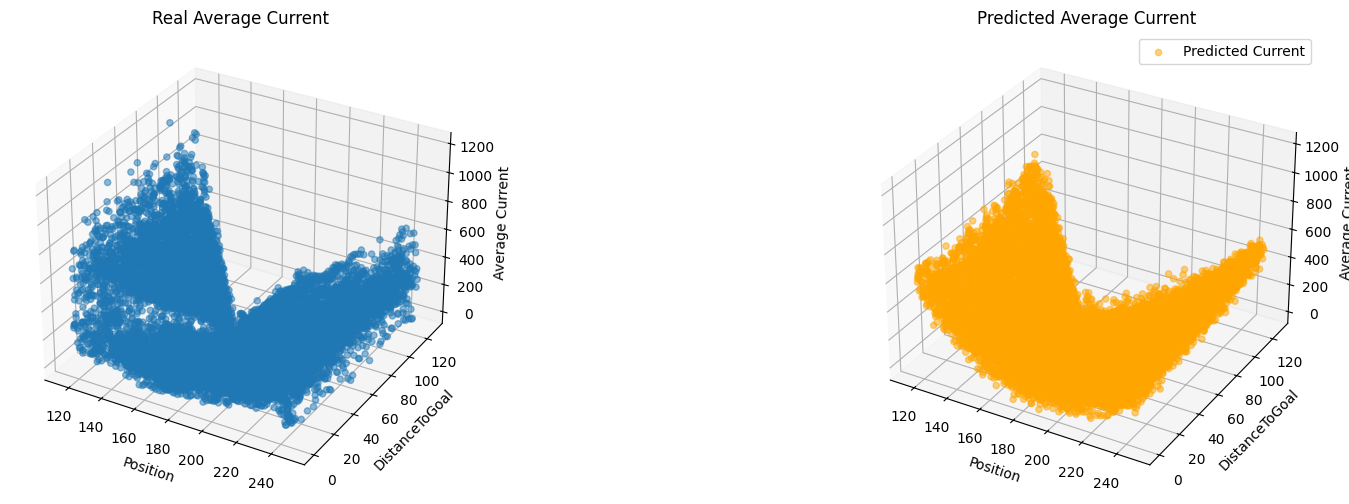

In [24]:
plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad, indep_var=['Position', 'DistanceToGoal'])

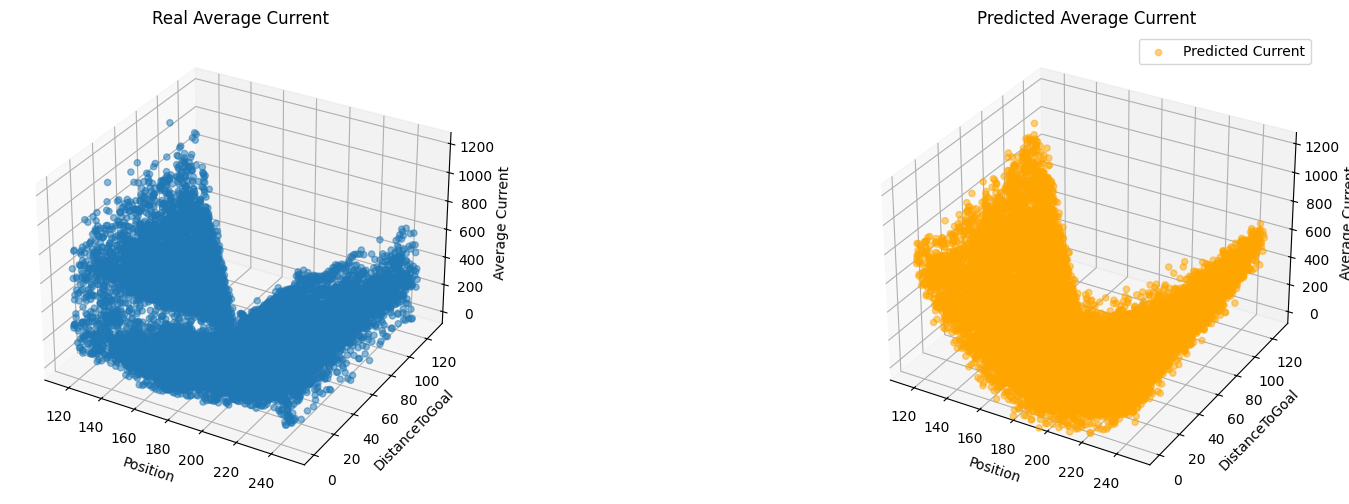

In [25]:
ppc_tilt_quad_scaled = ppc_tilt_quad.copy()
ppc_tilt_quad_scaled.posterior_predictive['AvgCurrent']*=1.4

plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad_scaled, indep_var=['Position', 'DistanceToGoal'])

In [28]:
with regression_tilt_model:
    pm.compute_log_likelihood(trace_tilt)

with regression_pan_model:
    pm.compute_log_likelihood(trace_pan)

with regression_tilt_model_quadradic:
    pm.compute_log_likelihood(trace_tilt_quad)

with regression_pan_model_quadradic:
    pm.compute_log_likelihood(trace_pan_quad)


Output()

Output()

Output()

Output()

In [29]:
tilt_model_comparison = az.compare({'tilt': trace_tilt, 'tilt_quad': trace_tilt_quad}, ic='waic')

In [30]:
tilt_model_comparison

rank     elpd_waic    p_waic   elpd_diff    weight          se  \
tilt_quad     0 -11424.321457  7.369966     0.00000  0.943898  105.357502   
tilt          1 -14942.542467  4.644120  3518.22101  0.056102   86.340951   

                 dse  warning scale  
tilt_quad   0.000000    False   log  
tilt       92.023891    False   log

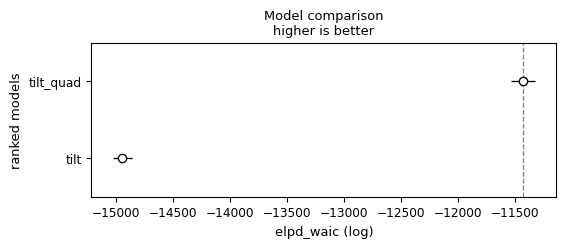

In [31]:
az.plot_compare(tilt_model_comparison)
plt.show()

In [32]:

pan_model_comparison_WAIC = az.compare({'pan': trace_pan, 'pan_quad': trace_pan_quad}, ic='waic')

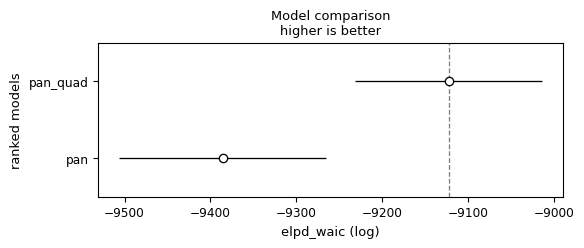

In [59]:
az.plot_compare(pan_model_comparison_WAIC)
plt.show()

<Axes: xlabel='AvgCurrent'>

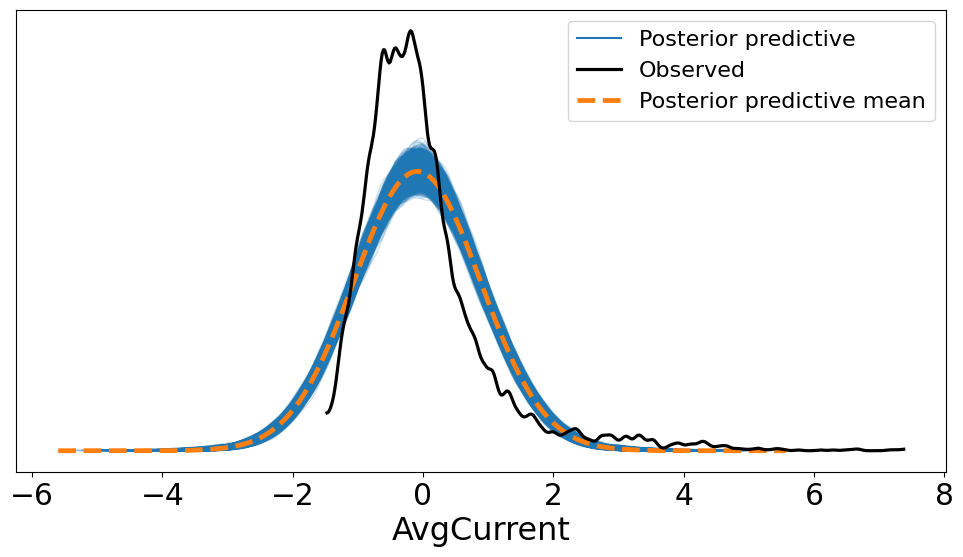

In [61]:
az.plot_ppc(ppc_pan_quad, data_pairs={"AvgCurrent": "AvgCurrent"}, figsize=(12, 6))

# Models using all the data

In [12]:
import os

# Define the file path for saving the trace
trace_file = 'models/trace_tilt_quad_all_std.nc'

# New tilt quadric model using all the data
data = std_all_data.copy()

with pm.Model() as regression_tilt_model_quadradic_all:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept - beta_position * data['tilt_pos'] + beta_distance * data['tilt_distance'] + beta_position2 * data['tilt_pos']**2

    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('tilt_current', mu=mu, sigma=sigma, observed=data['tilt_current'])

    if os.path.exists(trace_file):
        # Load the existing trace
        trace_tilt_quad_all = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_tilt_quad_all = pm.sample(3000, tune=1000, return_inferencedata=True, progressbar=True, cores=4)

        # Save the trace to a file
        az.to_netcdf(trace_tilt_quad_all, trace_file)

# Summarize the trace
az.summary(trace_tilt_quad_all)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_position   0.772  0.001   0.771    0.774      0.000    0.000   10922.0   
beta_distance   0.072  0.001   0.070    0.073      0.000    0.000   10910.0   
beta_position2  0.316  0.001   0.314    0.318      0.000    0.000    7504.0   
beta_distance2  0.002  1.977  -3.647    3.738      0.015    0.019   17169.0   
intercept      -0.316  0.001  -0.318   -0.314      0.000    0.000    8121.0   
sigma           0.498  0.000   0.497    0.499      0.000    0.000   16331.0   

                ess_tail  r_hat  
beta_position     9264.0    1.0  
beta_distance     8951.0    1.0  
beta_position2    8519.0    1.0  
beta_distance2    9512.0    1.0  
intercept         8854.0    1.0  
sigma             9136.0    1.0

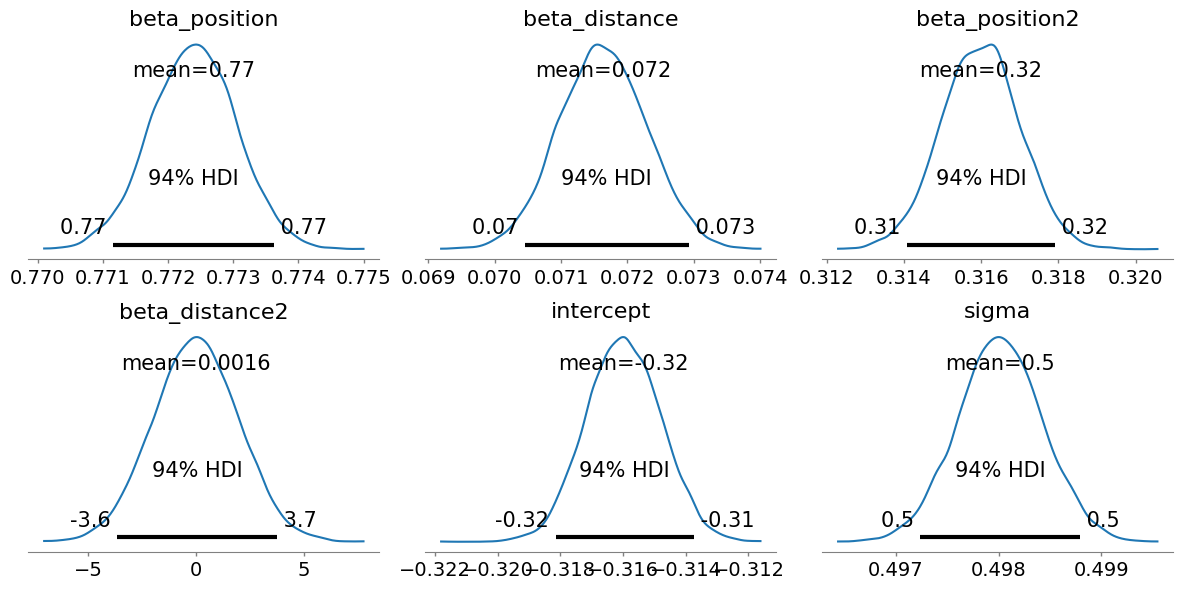

In [9]:
az.plot_posterior(trace_tilt_quad_all, var_names=['beta_position', 'beta_distance', 'beta_position2', 'beta_distance2', 'intercept', 'sigma'], figsize=(12, 6))
plt.tight_layout()
plt.show()

In [13]:
with regression_tilt_model_quadradic_all:
    approx = pm.fit(n=10000, method='advi')  # This is a variational inference method
    trace_tilt_quad_all = approx.sample(5000)


Output()

Finished [100%]: Average Loss = 7.039e+05


In [14]:
posterior_predictive_tilt_quad_all = pm.sample_posterior_predictive(trace_tilt_quad_all, model=regression_tilt_model_quadradic_all)

Sampling: [tilt_current]


Output()

In [16]:
posterior_predictive_tilt_quad_all 

Inference data with groups:
	> posterior_predictive
	> observed_data

In [20]:
# Define the file path for saving the trace
trace_file = 'models/trace_tilt_pan_interaction_all_std.nc'

# New tilt quadric model using all the data
data = std_all_data.copy()

with pm.Model() as regression_tilt_pan_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position_tilt = pm.Normal('beta_position_tilt', mu=0, sigma=1)
    beta_distance_tilt = pm.Normal('beta_distance_tilt', mu=0, sigma=1)
    beta_position_pan = pm.Normal('beta_position_pan', mu=0, sigma=1)
    beta_distance_pan = pm.Normal('beta_distance_pan', mu=0, sigma=1)
    beta_position_interaction = pm.Normal('beta_position_interaction', mu=0, sigma=1)
    beta_distance_interaction = pm.Normal('beta_distance_interaction', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    
    
    # Linear model equation
    mu_tilt = intercept + beta_position_tilt * data['tilt_pos'] + beta_distance_tilt * data['tilt_distance'] +  beta_position_interaction * data['tilt_pos'] * data['pan_pos'] + beta_distance_interaction * data['tilt_distance'] * data['pan_distance']
    # Likelihood (observed data is normally distributed around mu)
    likelihood_tilt = pm.Normal('TiltCurrent', mu=mu_tilt, sigma=sigma, observed=data['tilt_current'])

    mu_pan = intercept + beta_position_tilt * data['tilt_pos'] + beta_position_pan * data['pan_pos'] + beta_distance_pan * data['pan_distance'] + beta_position_interaction * data['tilt_pos'] * data['pan_pos'] + beta_distance_interaction * data['tilt_distance'] * data['pan_distance']
    likelihood_pan = pm.Normal('PanCurrent', mu=mu_pan, sigma=sigma, observed=data['pan_current'])
    

    if os.path.exists(trace_file):
        # Load the existing trace
        trace_tilt_pan = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_tilt_pan = pm.sample(3000, tune=1000, return_inferencedata=True, progressbar=True, cores=4)

        # Save the trace to a file
        az.to_netcdf(trace_tilt_pan, trace_file)

az.summary(trace_tilt_pan)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position_tilt, beta_distance_tilt, beta_position_pan, beta_distance_pan, beta_position_interaction, beta_distance_interaction, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 637 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position_tilt        -0.453  0.001  -0.454   -0.451        0.0      0.0   
beta_distance_tilt         0.102  0.001   0.100    0.104        0.0      0.0   
beta_position_pan          0.372  0.001   0.370    0.374        0.0      0.0   
beta_distance_pan         -0.119  0.001  -0.120   -0.117        0.0      0.0   
beta_position_interaction  0.202  0.001   0.201    0.204        0.0      0.0   
beta_distance_interaction -0.012  0.001  -0.014   -0.011        0.0      0.0   
intercept                  0.002  0.001   0.001    0.003        0.0      0.0   
sigma                      0.827  0.000   0.826    0.828        0.0      0.0   

                           ess_bulk  ess_tail  r_hat  
beta_position_tilt          14537.0    9454.0    1.0  
beta_distance_tilt          17407.0    9594.0    1.0  
beta_position_pan           16089.0    9229.0    1.0  
beta_distance_pan           14528.0    9742.0    1.0  
beta_position_interaction   14792.0    9180.0    1.0  
beta_distance_interaction   13441.0    9555.0    1.0  
intercept                   13958.0    8961.0    1.0  
sigma                       15365.0    9503.0    1.0

In [23]:
with regression_tilt_model_quadradic:
    pm.compute_log_likelihood(trace_tilt_quad)
with regression_tilt_model_quadradic_all:
    pm.compute_log_likelihood(trace_tilt_quad_all)

# plot the tilit current vs position and distance to goal in a topographic map
compare = az.compare({'tilt_quad': trace_tilt_quad, 'tilt_pan': trace_tilt_quad_all}, ic='waic')

Output()

: 